In [2]:
#Dependencies
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np
from dataset import ImageDataset

In [3]:
#Securing reproducability
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    #RandomAffine((0.05, 0.05)),
    #RandomHorizontalFlip(),
    #RandomVerticalFlip()
])

Loading the datasets

In [5]:

# class ImageDataset(Dataset):

#     def __init__(self, dataset_folder, dataset_type, transform=None):
#         self.dataset_folder = os.path.join(dataset_folder, dataset_type)
#         self.x = [f for f in os.listdir(self.dataset_folder) if f.endswith('.jpg')]
#         self.transform = transform


#     def __len__(self):
#         #return min(100, len(self.x))
#         return len(self.x)

#     def __getitem__(self, idx):
#         x = self.x[idx]
#         y = self.y[idx, 0, 0].astype(float)
#         if self.transform:
#             x = self.transform(x)
#         return x, y
    
#     def __getitem__(self, idx):
#         img_name = self.x[idx]
#         img_path = os.path.join(self.dataset_folder, img_name)
#         image = Image.open(img_path)
#         label = int(img_name.split('_')[0])
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

In [6]:
# train_dataset = ImageDataset("./data/resized_images", "train", ToTensor())
# print("Train dataset at index 5: ", train_dataset[5])
# print('Length train: ', len(train_dataset))

# test_dataset = ImageDataset("./data/resized_images", "test", ToTensor())
# print('Length test: ', len(test_dataset))

# valid_dataset = ImageDataset("./data/resized_images", "validation", ToTensor())
# print('Length validation: ', len(valid_dataset))

NameError: name 'train_dataset' is not defined

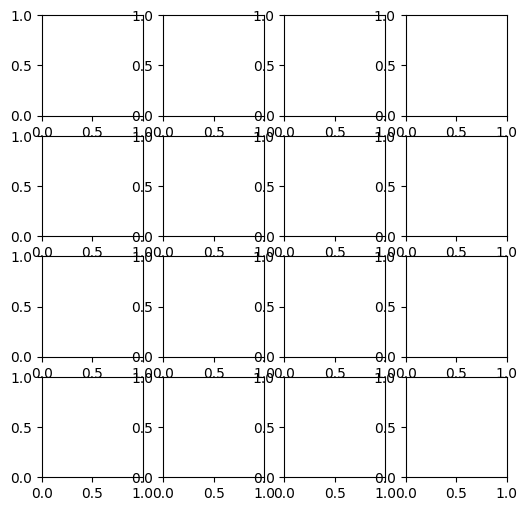

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {train_dataset[i][1]}")
plt.tight_layout()

In [ ]:
# batch_size = 64
# train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
# valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
# test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

Building the network

In [9]:
#Import dependencies
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from tqdm import tqdm

In [10]:
class Conv2d_bn(Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        if isinstance(kernel_size, tuple):
            padding_val = (k // 2 for k in kernel_size) if padding == "same" else (0,0)
        else:
            padding_val = kernel_size // 2 if padding == "same" else 0
        self.conv = Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding_val)
        self.bn = BatchNorm2d(out_filters)
        self.relu = ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [11]:
class StemBlock(Module):

    def __init__(self):
        super().__init__()
        self.first_block = Sequential(
            Conv2d_bn(in_filters=3, out_filters=32, kernel_size=3, strides=2, padding="valid"),
            Conv2d_bn(in_filters=32, out_filters=32, kernel_size=3, strides=1, padding="valid"),
            Conv2d_bn(in_filters=32, out_filters=64, kernel_size=3, strides=1, padding="same"),
        )
        self.first_left = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.first_right = Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=2, padding="valid")
        self.second_left =  Sequential(
            Conv2d_bn(in_filters=160, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="valid"),
        )
        self.second_right =  Sequential(
            Conv2d_bn(in_filters=160, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=64, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=64, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="valid"),
        )
        self.third_left = Conv2d_bn(in_filters=192, out_filters=192, kernel_size=3, strides=2, padding="valid")
        self.third_right = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.first_block(x)
        x_l = self.first_left(x)
        x_r = self.first_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        x_l = self.second_left(x)
        x_r = self.second_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        x_l = self.third_left(x)
        x_r = self.third_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        return x

In [12]:
class A_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=96, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=96, kernel_size=1, strides=1, padding="same")
        self.three_by_three_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="same"),
        )
        self.five_by_five =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(in_filters=96, out_filters=96, kernel_size=3, strides=1, padding="same"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_3 = self.three_by_three_block(x)
        x_4 = self.five_by_five(x)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        return x

In [13]:
class B_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=128, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same")

        self.seven_by_seven_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=(7, 1), strides=1, padding="same"),
        )

        self.thirteen_by_thirteen_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=192, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=(7, 1), strides=1, padding="same"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_3 = self.seven_by_seven_block(x)
        x_4 = self.thirteen_by_thirteen_block(x)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        return x

In [14]:
class C_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same")

        self.branch_a =  Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same")
        self.branch_a_left = Conv2d_bn(in_filters=384, out_filters=256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_a_right = Conv2d_bn(in_filters=384, out_filters=256, kernel_size=(3, 1), strides=1, padding="same")

        self.branch_b =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=384, out_filters=448, kernel_size=(1, 3), strides=1, padding="same"),
            Conv2d_bn(in_filters=448, out_filters=512, kernel_size=(3, 1), strides=1, padding="same"),
        )

        self.branch_b_left = Conv2d_bn(in_filters=512, out_filters=256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_b_right = Conv2d_bn(in_filters=512, out_filters=256, kernel_size=(3, 1), strides=1, padding="same")
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_a = self.branch_a(x)
        x_3 = self.branch_a_left(x_a)
        x_4 = self.branch_a_right(x_a)
        x_b = self.branch_b(x)
        x_5 = self.branch_b_left(x_b)
        x_6 = self.branch_b_right(x_b)
        x = torch.cat([x_1, x_2, x_3, x_4, x_5, x_6], axis=1)
        return x

In [15]:
class Reduction_A(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.central_block = Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=3, strides=2, padding="valid")
        self.right_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=3, strides=2, padding="valid"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x

In [16]:
class Reduction_B(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.central_block = Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=192, kernel_size=3, strides=2, padding="valid"),
        )
        self.right_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=256, out_filters=256, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=256, out_filters=320, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=320, out_filters=320, kernel_size=3, strides=2, padding="valid"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x

In [25]:
class InceptionV4(Module):

    def __init__(self):
        super().__init__()
        self.stem = StemBlock()
        self.inception_a = Sequential(
            A_block(384),
            A_block(384),
            A_block(384),
            A_block(384)
        )
        self.reduction_a = Reduction_A(384)
        self.inception_b = Sequential(
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024)
        )
        self.reduction_b = Reduction_B(1024)
        self.inception_c = Sequential(
            C_block(1536),
            C_block(1536),
            C_block(1536)
        )
        self.drop = Dropout(0.2)
        #self.out = Linear(1536, 1)
        self.out = Linear(1536, 75)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        x = x.reshape(x.shape[0], -1, 1536).mean(axis=1)
        x = self.drop(x)
        y = self.out(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [26]:
inception_v4 = InceptionV4()
print(inception_v4(torch.zeros(1, 3, 299, 299)).shape)
print("Expected shape (1, 1)")

torch.Size([1, 75])
Expected shape (1, 1)


In [27]:
model = InceptionV4()
opt = SGD(model.parameters(), lr=0.005)
#loss_fn = BCEWithLogitsLoss()
loss_fn = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf

if __name__ == "__main__":

    train_dataset = ImageDataset("./data/resized_images", "train", ToTensor())


    test_dataset = ImageDataset("./data/resized_images", "test", ToTensor())


    valid_dataset = ImageDataset("./data/resized_images", "validation", ToTensor())

    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

    for epoch in range(epochs):
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_dataloader)
        for batch_x, batch_y in iterator:
            print(len(batch_y))
            print(batch_x, batch_y)
            print("Size of batch_x:", batch_x.size())
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            loss = loss_fn(y_pred, batch_y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            for batch_x, batch_y in tqdm(valid_dataloader):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                y_pred = model(batch_x)

                predictions.append(y_pred)
                true.append(batch_y)
            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)
            val_loss = loss_fn(predictions, true)
            #val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
            val_acc = (predictions.argmax(dim=1) == true).float().mean()  # Use argmax for multi-class accuracy

            print(f"loss: {val_loss}, accuracy: {val_acc}")

        if val_loss < best_val:
            print("Saved Model")
            torch.save(model.state_dict(), "model.pt")
            best_val = val_loss

Epoch: 1


  0%|          | 0/251 [00:00<?, ?it/s]

64
tensor([[[[0.4627, 0.5137, 0.5294,  ..., 0.2275, 0.3020, 0.3725],
          [0.4000, 0.3843, 0.4078,  ..., 0.3020, 0.3059, 0.3255],
          [0.2863, 0.2431, 0.2667,  ..., 0.2706, 0.4745, 0.3765],
          ...,
          [0.6706, 0.6706, 0.6863,  ..., 0.6353, 0.6235, 0.6196],
          [0.6549, 0.6510, 0.6588,  ..., 0.6392, 0.6235, 0.6157],
          [0.6902, 0.6863, 0.6784,  ..., 0.6275, 0.6235, 0.6235]],

         [[0.4510, 0.5137, 0.5255,  ..., 0.2118, 0.2784, 0.3490],
          [0.3882, 0.3725, 0.4039,  ..., 0.2824, 0.2706, 0.2902],
          [0.2745, 0.2314, 0.2627,  ..., 0.2392, 0.4353, 0.3373],
          ...,
          [0.6588, 0.6706, 0.6745,  ..., 0.6118, 0.6000, 0.5961],
          [0.6392, 0.6392, 0.6431,  ..., 0.6157, 0.6000, 0.5922],
          [0.6745, 0.6706, 0.6627,  ..., 0.6039, 0.6000, 0.6000]],

         [[0.4235, 0.4824, 0.5059,  ..., 0.2078, 0.2863, 0.3569],
          [0.3608, 0.3451, 0.3843,  ..., 0.2706, 0.2745, 0.2941],
          [0.2392, 0.2039, 0.2431,  ...

  0%|          | 0/251 [00:30<?, ?it/s]


IndexError: Target 122 is out of bounds.